In [1]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification,AutoModelForSequenceClassification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_twitter = pd.read_csv("/content/drive/MyDrive/Twitter_Data.csv")
df_reddit = pd.read_csv("/content/drive/MyDrive/Reddit_Data.csv")

0 : Indicating it is a Neutral Tweet/Comment

1 : Indicating a Postive Sentiment

-1 : Indicating a Negative Tweet/Comment

In [4]:
df_twitter.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [5]:
df_reddit.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [6]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [7]:
df_reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [8]:
df_twitter.isnull().sum()

,0
clean_text,4
category,7


In [9]:
df_reddit.isnull().sum()

,0
clean_comment,100
category,0


In [10]:
df_twitter = df_twitter.dropna()
df_reddit = df_reddit.dropna()

In [11]:
df_twitter.isnull().sum()

,0
clean_text,0
category,0


In [12]:
df_reddit.isnull().sum()

,0
clean_comment,0
category,0


In [13]:
print(df_twitter.duplicated().sum())


0


In [14]:
print(df_reddit.duplicated().sum())

350


In [15]:
df_reddit = df_reddit.drop_duplicates()

In [16]:
print(df_reddit.duplicated().sum())

0


In [17]:
df_twitter.rename(columns = {'clean_text' : 'comment'}, inplace = True)
df_reddit.rename(columns = {'clean_comment' : 'comment'}, inplace = True)

In [18]:
df_twitter.head(1)

,comment,category
0,when modi promised “minimum government maximum...,-1.0


In [19]:
df_reddit.head(1)

,comment,category
0,family mormon have never tried explain them t...,1


In [20]:
df = pd.concat([df_twitter, df_reddit], axis = 0)
df.shape

(199768, 2)

In [21]:
# Shuffling the rows
df = df.sample(frac = 1).reset_index()

In [22]:
df

,index,comment,category
0,123757,that’ the equity which indian army and modi sh...,0.0
1,124499,another five years under modi will ensure reve...,0.0
2,44855,finally after years office indias modi has lea...,0.0
3,158421,leader goes hammer and tongs against meeting,0.0
4,73527,this the reason behind the credit goes modi,-1.0
...,...,...,...
199763,130171,again one more attack crpf soldiers why opposi...,1.0
199764,69521,congress latest weeping boy weeping every modi...,1.0
199765,43453,live modis address the nation\nfor more detail...,1.0
199766,557,thats some build you got there,0.0


0 : Indicating it is a Neutral Tweet/Comment

1 : Indicating a Postive Sentiment

-1 : Indicating a Negative Tweet/Comment

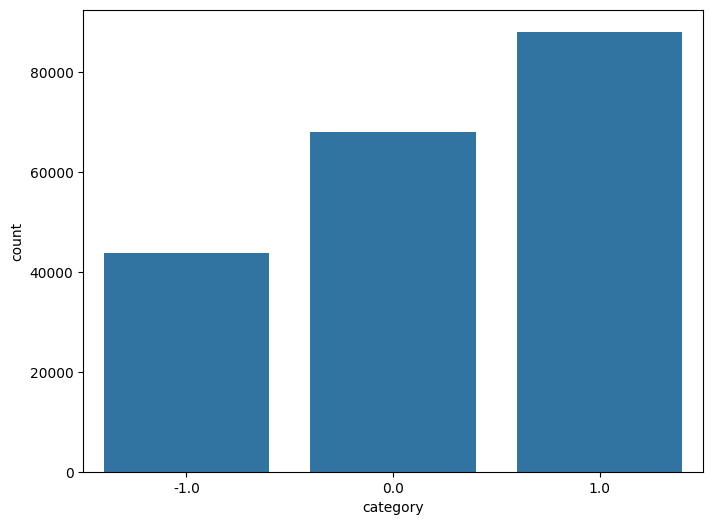

In [23]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'category', data = df)
plt.show()

In [24]:
comments = " ".join(df['comment'].tolist())

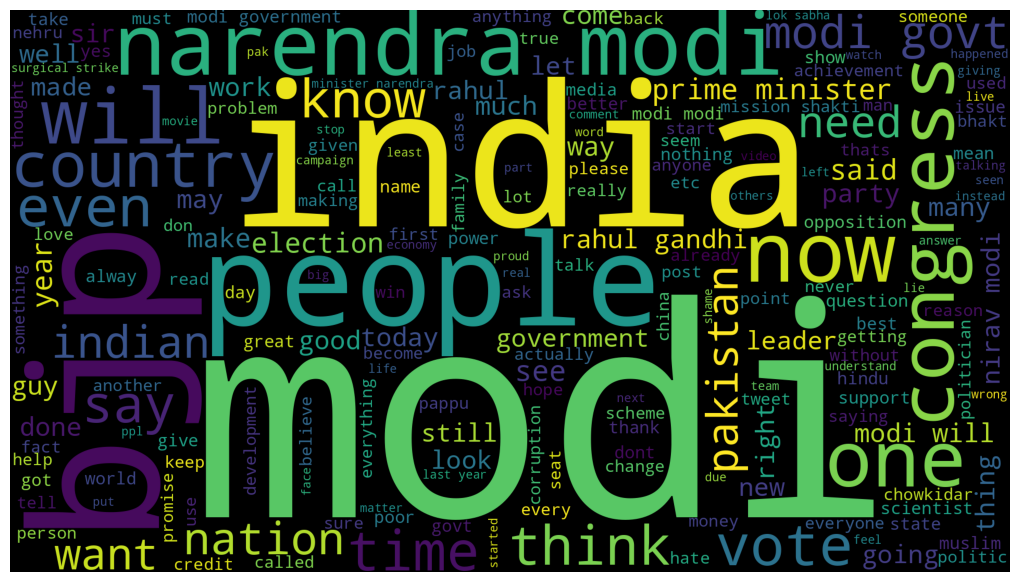

In [25]:
wordcloud = WordCloud(width=1920, height=1080).generate(comments)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [26]:
texts = df['comment'].tolist()

In [27]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    df['comment'].to_numpy(),
    df['category'].to_numpy(),
    test_size=0.1,          # 10% test set
    random_state=42,
    shuffle=True
)

#  Validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,          # 10% of train → validation
    random_state=42,
    shuffle=True
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 161811
Validation size: 17980
Test size: 19977


In [28]:
# Convert to flat strings (avoid nested lists)
def flatten_text_list(text_list):
    return [str(x[0]) if isinstance(x, list) else str(x) for x in text_list]

X_train = flatten_text_list(X_train)
X_val   = flatten_text_list(X_val)
X_test  = flatten_text_list(X_test)


In [29]:
# 5️⃣ Tokenizer and model settings
max_len = 32  # small length to save memory
model_name = "distilbert-base-uncased"  # smaller than full BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [30]:
 # Batch tokenization function
def encode_texts_in_batches(texts, batch_size=50):
    input_ids_list = []
    attention_mask_list = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(
            batch_texts,
            truncation=True,
            padding='max_length',
            max_length=max_len,
            return_tensors='tf'
        )
        input_ids_list.append(enc['input_ids'])
        attention_mask_list.append(enc['attention_mask'])
    return {
        'input_ids': tf.concat(input_ids_list, axis=0),
        'attention_mask': tf.concat(attention_mask_list, axis=0)
    }

train_encodings = encode_texts_in_batches(X_train)
val_encodings   = encode_texts_in_batches(X_val)
test_encodings  = encode_texts_in_batches(X_test)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [31]:
# TensorFlow datasets
batch_size = 4
train_dataset = tf.data.Dataset.from_tensor_slices((train_encodings, y_train)).shuffle(100).batch(batch_size)
val_dataset   = tf.data.Dataset.from_tensor_slices((val_encodings, y_val)).batch(batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices((test_encodings, y_test)).batch(batch_size)

In [32]:
# Load the DistilBERT model
num_labels = 3
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, use_safetensors=False)

tf_model.h5:   0%|          | 0.00/363M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-

In [33]:
# Compile model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [35]:
# Train model
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2)

Epoch 1/2
40453/40453 [==============================] - 1605s 40ms/step - loss: nan - accuracy: 0.3399 - val_loss: nan - val_accuracy: 0.3391
Epoch 2/2
40453/40453 [==============================] - 1586s 39ms/step - loss: nan - accuracy: 0.3399 - val_loss: nan - val_accuracy: 0.3391


In [36]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

4995/4995 [==============================] - 91s 18ms/step - loss: nan - accuracy: 0.3451
Test Accuracy: 0.3451
